# Fetching data from a CSW catalog with Python tools

This notebook shows a typical workflow to query a [Catalog Service for the Web (CSW)](https://en.wikipedia.org/wiki/Catalog_Service_for_the_Web) and create a request for data endpoints that are suitable for download.

In this queries multiple catalogs for the near real time HF-Radar current data.

The first step is to create the data filter based on the geographical region bounding box, the time span, and the CF variable standard name.

In [1]:
from datetime import datetime, timedelta

# Region: West coast.
min_lon, max_lon = -123, -121
min_lat, max_lat = 36, 40

bbox = [min_lon, min_lat, max_lon, max_lat]
crs = 'urn:ogc:def:crs:OGC:1.3:CRS84'

# Temporal range: Last week.
now = datetime.utcnow()
start, stop = now - timedelta(days=(7)), now

# Surface velocity CF names.
cf_names = ['surface_northward_sea_water_velocity',
            'surface_eastward_sea_water_velocity']

Now it is possible to assemble a [OGC Filter Encoding (FE)](http://www.opengeospatial.org/standards/filter) for the search using `owslib.fes`\*. Note that the final result is only a list with all the filtering conditions.

\* OWSLib is a Python package for client programming with Open Geospatial Consortium (OGC) web service (hence OWS) interface standards, and their related content models.

In [2]:
from owslib import fes


def fes_date_filter(start, stop, constraint='overlaps'):
    """
    Take datetime-like objects and returns a fes filter for date range
    (begin and end inclusive).
    NOTE: Truncates the minutes!!!

    Examples
    --------
    >>> from datetime import datetime, timedelta
    >>> stop = datetime(2010, 1, 1, 12, 30, 59).replace(tzinfo=pytz.utc)
    >>> start = stop - timedelta(days=7)
    >>> begin, end = fes_date_filter(start, stop, constraint='overlaps')
    >>> begin.literal, end.literal
    ('2010-01-01 12:00', '2009-12-25 12:00')
    >>> begin.propertyoperator, end.propertyoperator
    ('ogc:PropertyIsLessThanOrEqualTo', 'ogc:PropertyIsGreaterThanOrEqualTo')
    >>> begin, end = fes_date_filter(start, stop, constraint='within')
    >>> begin.literal, end.literal
    ('2009-12-25 12:00', '2010-01-01 12:00')
    >>> begin.propertyoperator, end.propertyoperator
    ('ogc:PropertyIsGreaterThanOrEqualTo', 'ogc:PropertyIsLessThanOrEqualTo')

    """
    start = start.strftime('%Y-%m-%d %H:00')
    stop = stop.strftime('%Y-%m-%d %H:00')
    if constraint == 'overlaps':
        propertyname = 'apiso:TempExtent_begin'
        begin = fes.PropertyIsLessThanOrEqualTo(propertyname=propertyname,
                                                literal=stop)
        propertyname = 'apiso:TempExtent_end'
        end = fes.PropertyIsGreaterThanOrEqualTo(propertyname=propertyname,
                                                 literal=start)
    elif constraint == 'within':
        propertyname = 'apiso:TempExtent_begin'
        begin = fes.PropertyIsGreaterThanOrEqualTo(propertyname=propertyname,
                                                   literal=start)
        propertyname = 'apiso:TempExtent_end'
        end = fes.PropertyIsLessThanOrEqualTo(propertyname=propertyname,
                                              literal=stop)
    else:
        raise NameError('Unrecognized constraint {}'.format(constraint))
    return begin, end

In [3]:
kw = dict(wildCard='*', escapeChar='\\',
          singleChar='?', propertyname='apiso:AnyText')

or_filt = fes.Or([fes.PropertyIsLike(literal=('*%s*' % val), **kw)
                  for val in cf_names])

# Exclude GNOME returns.
not_filt = fes.Not([fes.PropertyIsLike(literal='*GNOME*', **kw)])

begin, end = fes_date_filter(start, stop)
bbox_crs = fes.BBox(bbox, crs=crs)
filter_list = [fes.And([bbox_crs, begin, end, or_filt, not_filt])]

It is possible to use the same filter to search multiple catalogs. The cell below loops over 3 catalogs hoping to find which one is more up-to-date and returns the near real time data.

In [4]:
def get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000):
    """Iterate `maxrecords`/`pagesize` times until the requested value in
    `maxrecords` is reached.
    """
    from owslib.fes import SortBy, SortProperty
    # Iterate over sorted results.
    sortby = SortBy([SortProperty('dc:title', 'ASC')])
    csw_records = {}
    startposition = 0
    nextrecord = getattr(csw, 'results', 1)
    while nextrecord != 0:
        csw.getrecords2(constraints=filter_list, startposition=startposition,
                        maxrecords=pagesize, sortby=sortby)
        csw_records.update(csw.records)
        if csw.results['nextrecord'] == 0:
            break
        startposition += pagesize + 1  # Last one is included.
        if startposition >= maxrecords:
            break
    csw.records.update(csw_records)

In [5]:
from owslib.csw import CatalogueServiceWeb


endpoint = 'https://data.ioos.us/csw'

csw = CatalogueServiceWeb(endpoint, timeout=60)
get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)

records = '\n'.join(csw.records.keys())
print('Found {} records.\n'.format(len(csw.records.keys())))
for key, value in list(csw.records.items()):
    print('[{}]: {}'.format(value.title, key))

Found 8 records.

[CeNCOOS/Models/ROMS/California ROMS/California Coastal Regional Ocean Modeling System (ROMS) Nowcast]: CA_DAS
[HYbrid Coordinate Ocean Model (HYCOM): Global]: hycom_global
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
1 km Resolution]: e1a153d0-1ca6-476b-b08f-aced8c8a20ed
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
2 km Resolution]: 55c7a051-3074-4061-9fa0-8012cd26f4f8
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
500 m Resolution]: 8a0b8e3d-914a-4629-9f05-c1f12d17a24a
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
6 km Resolution]: c1fc179d-d567-4934-9720-29ae2b0f687c
[NOAA/NCEP Global Forecast System (GFS) Atmospheric Model]: ncep_global
[UCSC California Current System ROMS Nowcast 10km]: UCSC


# !!FIXME!!!

None of those looks like NDBC endpotins!

Found some weird named data (looks like `uuid`) and some model/reanalysis data, .
The weird data may be what we are looking for.
Let's dig further using the 6 km resolution data.

In [6]:
value = csw.records['c1fc179d-d567-4934-9720-29ae2b0f687c']

print(value.abstract)

Surface ocean velocities estimated from HF-Radar are
representative of the upper 0.3 - 2.5 meters of the
ocean.  The main objective of near-real time
processing is to produce the best product from
available data at the time of processing.  Radial
velocity measurements are obtained from individual
radar sites through the U.S. HF-Radar Network.
Hourly radial data are processed by unweighted
least-squares on a 6 km resolution grid of the U.S.
West Coast to produce near real-time surface current
maps.


Based on the record abstract it seems that  this is exactly what we want.

The next step is to inspect the type services/schemes available for downloading the data. The easiest way to accomplish that is with by "sniffing" the URLs with `geolinks`.

In [7]:
from geolinks import sniff_link

msg = 'geolink: {geolink}\nscheme: {scheme}\nURL: {url}\n'.format
for ref in value.references:
    print(msg(geolink=sniff_link(ref['url']), **ref))

For a detailed description of what those `geolink` results mean check the [lookup](https://github.com/OSGeo/Cat-Interop/blob/master/LinkPropertyLookupTable.csv) table.
There are Web Coverage Service (WCS), Web Map Service (WMS),
direct links, and OPeNDAP (identified as `None` !?) services available.

The easiest one to explore is the open OPeNDAP endpoint.
The next 5 cells downloads and plot the current data for the day before,
to check if the endpoint is indeed near real time.

# !!FIXME!!!

Hardcoding the NDBC OPenDAP endpoint for now.

In [8]:
import xarray as xr

url = 'http://sdf.ndbc.noaa.gov/thredds/dodsC/hfradar_uswc_6km'

ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:       (lat: 367, lon: 234, nProcParam: 7, nSites: 44, time: 118)
Coordinates:
  * lat           (lat) float32 30.25 30.3039 30.3579 30.4118 30.4658 ...
  * lon           (lon) float32 -130.36 -130.298 -130.235 -130.173 -130.11 ...
  * time          (time) |S64 b'2017-04-29T23:00:00Z' ...
Dimensions without coordinates: nProcParam, nSites
Data variables:
    site_lat      (nSites) float32 ...
    site_lon      (nSites) float32 ...
    site_code     (nSites) |S64 ...
    site_netCode  (nSites) |S64 ...
    procParams    (nProcParam) float32 ...
    u             (time, lat, lon) float64 ...
    v             (time, lat, lon) float64 ...
    DOPx          (time, lat, lon) float64 ...
    DOPy          (time, lat, lon) float64 ...
Attributes:
    netcdf_library_version:  4.1.3
    format_version:          HFRNet_1.0.0
    product_version:         HFRNet_1.1.05
    Conventions:             CF-1.1
    title:                   Near-Real Time Surface Ocean Velocity

Select "yesterday" data.

# !!FIXME!!!

For some reason the dates are not CF-compliant and need to be parsed before we can work with them.

In [9]:
ds['time'] = [datetime.strptime(date.decode(), '%Y-%m-%dT%H:%M:%SZ') for date in ds['time'].data]

In [10]:
from datetime import date, timedelta

yesterday = date.today() - timedelta(days=1)

ds = ds.sel(time=yesterday)

Compute the speed while masking invalid values.

In [11]:
import numpy.ma as ma

u = ds['u'].data
v = ds['v'].data

lon = ds.coords['lon'].data
lat = ds.coords['lat'].data
time = ds.coords['time'].data

u = ma.masked_invalid(u)
v = ma.masked_invalid(v)

This cell is only a trick to show all quiver arrows with the same length,
for visualization purposes,
and indicate the vector magnitude with colors instead.

In [12]:
import numpy as np
from oceans import uv2spdir, spdir2uv

angle, speed = uv2spdir(u, v)
us, vs = spdir2uv(np.ones_like(speed), angle, deg=True)

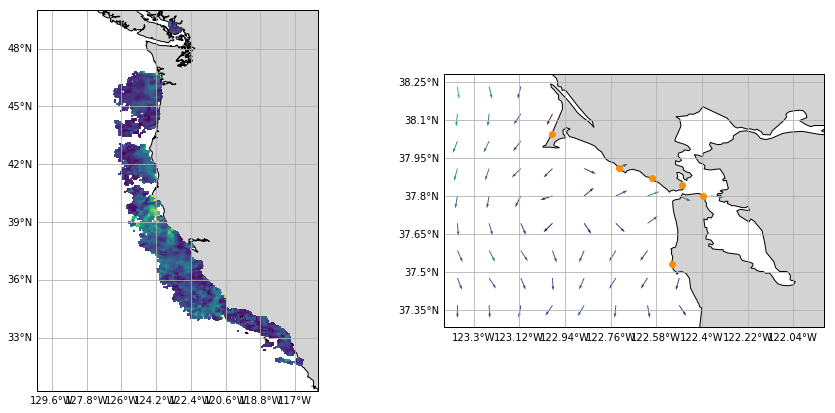

In [13]:
%matplotlib inline

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from cartopy import feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

LAND = feature.NaturalEarthFeature('physical', 'land', '10m',
                                   edgecolor='face',
                                   facecolor='lightgray')

sub = 2
dx = dy = 0.5
center = -122.416667, 37.783333  # San Francisco.
bbox = lon.min(), lon.max(), lat.min(), lat.max()

fig, (ax0, ax1) = plt.subplots(
    ncols=2,
    figsize=(15, 7),
    subplot_kw=dict(projection=ccrs.PlateCarree())
)


ax0.set_extent(bbox)
ax0.pcolormesh(lon, lat, ma.masked_invalid(speed))
gl = ax0.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax0.add_feature(LAND, zorder=0, edgecolor='black')


ax1.set_extent([center[0]-dx-dx, center[0]+dx, center[1]-dy, center[1]+dy])
ax1.quiver(lon[::sub], lat[::sub],
           us[::sub, ::sub], vs[::sub, ::sub],
           speed[::sub, ::sub], scale=30)
gl = ax1.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax1.add_feature(LAND, zorder=0, edgecolor='black')
ax1.plot(ds['site_lon'], ds['site_lat'], marker='o', linestyle='none', color='darkorange')

And here is yesterday's sea surface currents from the west coast with a zoom in the bay area.


<br>
Right click and choose Save link as... to
[download](https://raw.githubusercontent.com/ioos/notebooks_demos/master/notebooks/2016-11-20-finding_HFRadar_currents.ipynb)
this notebook, or see a static view
[here](http://nbviewer.ipython.org/urls/raw.githubusercontent.com/ioos/notebooks_demos/master/notebooks/2016-11-20-finding_HFRadar_currents.ipynb).

# !!FIXME!!!

Retry the search without the date filter to check if we can find the NDBC data.

In [14]:
filter_list = [
    fes.And(
        [
            bbox_crs,
            begin,
            end,
            or_filt,
            not_filt,
            fes.Not([fes.PropertyIsLike(literal='*FVCOM*', **kw)]),
            fes.Not([fes.PropertyIsLike(literal='*ROMS*', **kw)]),
            fes.Not([fes.PropertyIsLike(literal='*SELFE*', **kw)]),
            fes.Not([fes.PropertyIsLike(literal='*ncep_global*', **kw)]),
            fes.Not([fes.PropertyIsLike(literal='*hycom_global*', **kw)]),
        ]
    )
]


csw = CatalogueServiceWeb(endpoint, timeout=60)
get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)

records = '\n'.join(csw.records.keys())
print('Found {} records.\n'.format(len(csw.records.keys())))
for key, value in list(csw.records.items()):
    print('[{}]: {}'.format(value.title, key))

Found 4 records.

[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
1 km Resolution]: e1a153d0-1ca6-476b-b08f-aced8c8a20ed
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
2 km Resolution]: 55c7a051-3074-4061-9fa0-8012cd26f4f8
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
500 m Resolution]: 8a0b8e3d-914a-4629-9f05-c1f12d17a24a
[Near-Real Time Surface Ocean Velocity, U.S. West Coast,
6 km Resolution]: c1fc179d-d567-4934-9720-29ae2b0f687c


In [15]:
# hfradar_uswc_6km
value = csw.records['c1fc179d-d567-4934-9720-29ae2b0f687c']

print(value.abstract)

Surface ocean velocities estimated from HF-Radar are
representative of the upper 0.3 - 2.5 meters of the
ocean.  The main objective of near-real time
processing is to produce the best product from
available data at the time of processing.  Radial
velocity measurements are obtained from individual
radar sites through the U.S. HF-Radar Network.
Hourly radial data are processed by unweighted
least-squares on a 6 km resolution grid of the U.S.
West Coast to produce near real-time surface current
maps.


In [16]:
from geolinks import sniff_link

msg = 'geolink: {geolink}\nscheme: {scheme}\nURL: {url}\n'.format
for ref in value.references:
    print(msg(geolink=sniff_link(ref['url']), **ref))

In [17]:
value.references

[]

# !!FIXME!!!

It is worth noting that the OPeNDAP endpoint has both geolink and scheme as `None` making it impossible to identify automagically.